In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import cv2

FILES_DIR = os.path.abspath('images')
pd.set_option('display.width', 1000)

In [122]:
def haralickDescriptors(image, distance, angle):
	height, width = image.shape
	maxIntensity = np.max(image)

	dy, dx = (0, 1)
	if angle == 45:
		dy, dx = (1, 1)
	elif angle == 90:
		dy, dx = (1, 0)
	elif angle == 135:
		dy, dx = (1, -1)

	coOcurrenceMatrix = np.zeros((maxIntensity + 1, maxIntensity + 1), dtype = np.uint8)

	for y in range(height):
		for x in range(width):
			if (x + distance * dx) < width and (y + distance * dy) < height:
				coOcurrenceMatrix[image[y, x], image[y + distance * dy, x + distance * dx]] += 1

	coOcurrenceMatrix = coOcurrenceMatrix.astype(float) / np.sum(coOcurrenceMatrix)
	coOcurrenceMatrix[coOcurrenceMatrix == 0] = 1e-10

	secondAngularMoment, entropy, contrast = (0, 0, 0)

	for y in range(coOcurrenceMatrix.shape[0]):
		for x in range(coOcurrenceMatrix.shape[1]):
			secondAngularMoment += coOcurrenceMatrix[y, x] ** 2
			entropy -= coOcurrenceMatrix[y, x] * np.log2(coOcurrenceMatrix[y, x])
			contrast += (y - x) ** 2 * coOcurrenceMatrix[y, x]

	return secondAngularMoment, entropy, contrast

def calcLocalBinaryPattern(image, imageName):
	lbpImage = np.copy(image)
	path = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

	for y in range(1, image.shape[0] - 1):
		for x in range(1, image.shape[1] - 1):
			bin = []
			pos = [(y + a, x + b) for a, b in path]

			for j, i in pos:
				bin.append(0 if image[j, i] < image[y, x] else 1)
			
			lbpImage[y, x] = sum(bit * (2 ** i) for i, bit in enumerate(bin))

	cv2.imwrite(f'{FILES_DIR}/localBinaryPattern/{imageName}_lbp.png', lbpImage)
	
	hist, _ = np.histogram(lbpImage.ravel(), bins = np.max(lbpImage))
	cdf = np.cumsum(hist)

	return np.average(cdf / cdf[-1])

def calcFractalDimension(image, imageName):
	boxSizes = np.power(2, np.arange(1, 7))
	boxCounts = []

	for size in boxSizes:
		count = 0

		for i in range(0, image.shape[0], size):
			for j in range(0, image.shape[1], size):
				uniqueIntensities = np.unique(image[i:i + size, j:j + size])
				count += math.ceil(np.max(uniqueIntensities) / size)

		boxCounts.append(count)

	logEpsilon = np.log(boxSizes)
	logBoxCounts = np.log(boxCounts)

	m, c = np.linalg.lstsq(np.vstack([logEpsilon, np.ones(len(logEpsilon))]).T, logBoxCounts, rcond = None)[0]

	fractalDimension = -m
	partialfractalDimension = [-m * np.log(e) for e in boxSizes[:2]]

	plt.figure()
	plt.plot(np.log(boxSizes), np.log(boxCounts), 'o-', label='Quantidade de Caixas')
	plt.xlabel('Log(tamanho da caixa)')
	plt.ylabel('Log(quantidade de caixas)')
	plt.grid(True)
	plt.title(f'Dimensão Fractal: {fractalDimension}')
	plt.savefig(f'{FILES_DIR}/fractalDimension/fractalDimension_{imageName}.png')
	plt.close()

	return fractalDimension, partialfractalDimension

def showFeatures(items, features, columns):	
	df = pd.DataFrame(features, columns = columns, index = items)
	print(df)

def featureSpace(items, features, columns, type):
	features = np.array(features)

	featureOne = features[:, 0]
	featureTwo = features[:, 1]
	featureThree = features[:, 2]

	fig = plt.figure(figsize = (8, 6))
	colors = np.random.rand(len(items), 3)

	ax = fig.add_subplot(111, projection = '3d')

	for i, item in enumerate(items):
		ax.scatter(featureOne[i], featureTwo[i], featureThree[i], marker = 'o', c = np.array(colors[i]).reshape(1, -1), s = 50, label = item)
	
	ax.legend()
	ax.set_title(f'Espaço de Características ({type})')
	
	ax.set_xlabel(columns[0])
	ax.set_ylabel(columns[1])
	ax.set_zlabel(columns[2])

	plt.savefig(f'{FILES_DIR}/features/spaceFeatures_{type}.png')
	plt.show()

      Segundo Momento Angular   Entropia   Contraste  Local Binary Pattern  Dimensão Fractal  Dimensão Fractal (It. 1)  Dimensão Fractal (It. 2)
R0_1                 0.000163  13.217329  215.104288              0.463593          2.836345                  1.966005                  3.932009
R0_2                 0.000210  12.961387  247.301836              0.460487          2.875808                  1.993358                  3.986716
R3_1                 0.000148  13.698890  460.404328              0.471159          2.774533                  1.923160                  3.846320
R3_2                 0.000094  14.262727  946.958865              0.472375          2.823648                  1.957203                  3.914407


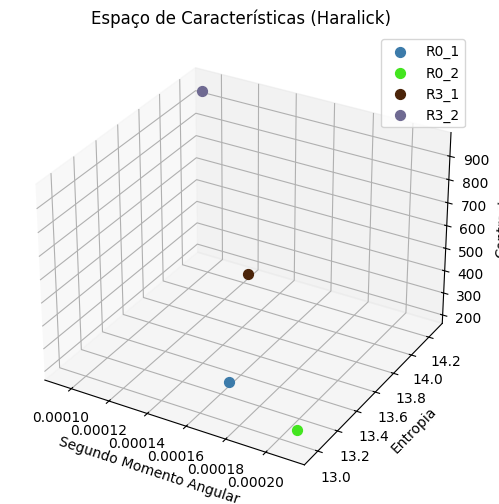

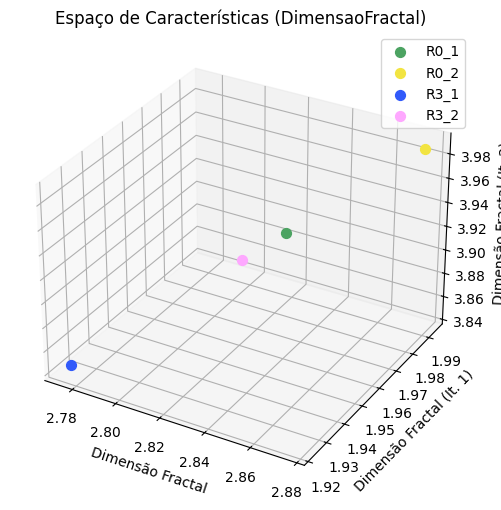

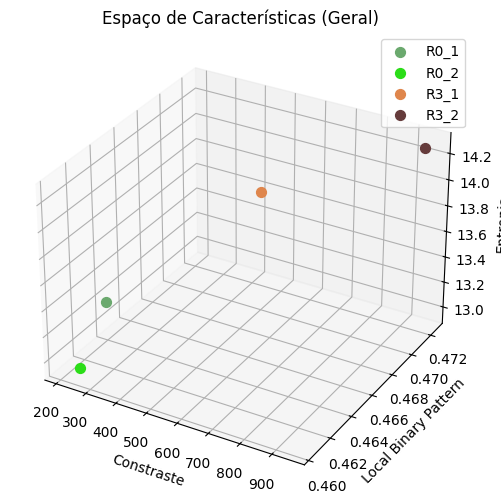

In [123]:
images = ['R0_1', 'R0_2', 'R3_1', 'R3_2']

features = []
spaceFeaturesHaralick = []
spaceFeaturesFractalDimension = []
spaceFeaturesGeneral = []

featuresLabel = ['Segundo Momento Angular', 'Entropia', 'Contraste', 'Local Binary Pattern', 'Dimensão Fractal', 'Dimensão Fractal (It. 1)', 'Dimensão Fractal (It. 2)']
spaceFeatureHaralickLabel = ['Segundo Momento Angular', 'Entropia', 'Contraste']
spaceFeatureFractalDimensionLabel = ['Dimensão Fractal', 'Dimensão Fractal (It. 1)', 'Dimensão Fractal (It. 2)']
spaceFeaturesGeneralLabel = ['Constraste', 'Local Binary Pattern', 'Entropia']

for imageName in images:
	image = cv2.cvtColor(cv2.imread(f'{FILES_DIR}/original/{imageName}.JPG'), cv2.COLOR_RGB2GRAY)

	fractalDimension, partialfractalDimension = calcFractalDimension(image, imageName)
	secondAngularMoment, entropy, contrast = haralickDescriptors(image, distance = 1, angle = 0)
	localBinaryPattern = calcLocalBinaryPattern(image, imageName)

	features.append([secondAngularMoment, entropy, contrast, localBinaryPattern, fractalDimension, partialfractalDimension[0], partialfractalDimension[1]])
	spaceFeaturesHaralick.append([secondAngularMoment, entropy, contrast])
	spaceFeaturesFractalDimension.append([fractalDimension, partialfractalDimension[0], partialfractalDimension[1]])
	spaceFeaturesGeneral.append([contrast, localBinaryPattern, entropy])

showFeatures(images, features, featuresLabel) 

featureSpace(images, spaceFeaturesHaralick, spaceFeatureHaralickLabel, 'Haralick')
featureSpace(images, spaceFeaturesFractalDimension, spaceFeatureFractalDimensionLabel, 'DimensaoFractal')
featureSpace(images, spaceFeaturesGeneral, spaceFeaturesGeneralLabel, 'Geral')